In [1]:
from pathlib import Path
from datetime import datetime
import json
import simplejson

EXPERIMENT_FOLDER = "./experiments/channel_permutation"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [4]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [5]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [8]:
def create_message_permutation_experiment(channel_size=5, **exp_kwargs):
    
    agent = Agent(channel_size, NUM_CLASSES)

    play_params =  {
        'channel_size': channel_size,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )


def create_message_permutation_is_all_you_need_experiment(channel_size=5, epochs=300, **exp_kwargs):
    
    agent = Agent(channel_size, NUM_CLASSES)

    play_params =  {
        'channel_size': channel_size,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=25,
        **exp_kwargs
    )

In [9]:
permutation_experiment = MetaExperiment(
    create_experiment_fn=create_message_permutation_is_all_you_need_experiment,
    num_experiments=6,
    export_location=EXPERIMENT_FOLDER,
)

In [13]:
permutation_experiment.run()

Running meta_experiment...
Test Loss: 2.323, Ground Truth F1-Score: 0.671, Student Error: 3.601, Teacher Error: 9.374, Protocol Diversity: 0.777,
Test Loss: 0.483, Ground Truth F1-Score: 0.644, Student Error: 2.432, Teacher Error: 10.065, Protocol Diversity: 0.5,
Test Loss: 0.458, Ground Truth F1-Score: 0.682, Student Error: 2.19, Teacher Error: 9.468, Protocol Diversity: 0.5,
Test Loss: 0.064, Ground Truth F1-Score: 0.984, Student Error: 0.064, Teacher Error: 10.579, Protocol Diversity: 1.0,
Test Loss: 0.635, Ground Truth F1-Score: 0.615, Student Error: 2.48, Teacher Error: 9.881, Protocol Diversity: 0.5,
Test Loss: 0.469, Ground Truth F1-Score: 0.672, Student Error: 2.278, Teacher Error: 10.073, Protocol Diversity: 0.5,
Run Stopped.


In [21]:
for item in permutation_experiment.experiments:
    if item['status'] == 'Complete':
        total_time = sum([
            x['seconds_taken']
            for x in item['experiment'].training_history
        ])
        print(total_time)

3740.8800749778748
4944.289919137955
6012.430957794189
7008.578038692474
9122.785410165787
10250.85593533516


In [20]:
permutation_experiment.experiments

[{'experiment': <zscomm.experiment.Experiment at 0x232bc1a6908>,
  'status': 'Complete',
  'results': {'mean_test_loss': 2.322507381439209,
   'mean_ground_truth_f1': 0.67125,
   'mean_student_error': 3.6012609004974365,
   'mean_teacher_error': 9.373649597167969,
   'mean_protocol_diversity': 0.7774999737739563},
  'index': 0},
 {'experiment': <zscomm.experiment.Experiment at 0x232bc1fbc18>,
  'status': 'Complete',
  'results': {'mean_test_loss': 0.4827045798301697,
   'mean_ground_truth_f1': 0.64375,
   'mean_student_error': 2.4317660331726074,
   'mean_teacher_error': 10.065320014953613,
   'mean_protocol_diversity': 0.5},
  'index': 1},
 {'experiment': <zscomm.experiment.Experiment at 0x232bc233f28>,
  'status': 'Complete',
  'results': {'mean_test_loss': 0.4583479166030884,
   'mean_ground_truth_f1': 0.6825,
   'mean_student_error': 2.189865827560425,
   'mean_teacher_error': 9.468042373657227,
   'mean_protocol_diversity': 0.5},
  'index': 2},
 {'experiment': <zscomm.experiment.E

## Analyse Results

In [16]:
def load_channel_permutation_experiment(path):
    
    config = json.load((path / 'config.json').open(mode='r'))
    results = json.load((path / 'results.json').open(mode='r'))
    history = json.load((path / 'training_history.json').open(mode='r'))
    
    agent = Agent(config['play_params']['channel_size'], NUM_CLASSES)
    agent.load_weights(str(path / 'agent_weights'))
    
    config['loss_fn'] = student_pred_matches_test_class
    
    kwargs = {
        k: v for k, v in config.items()
        if k not in ['epochs_optimised', 'optimiser_config']
    }
    experiment = Experiment(
        generate_train_batch, generate_test_batch,
        student=agent,
        teacher=agent,
        **kwargs
    )
    experiment.epoch = config['epochs_optimised']
    experiment.training_history = history
    experiment.results = results
    
    return experiment

In [17]:
experiments = []
for path in Path(EXPERIMENT_FOLDER).glob('*'):
    if not path.is_file():
        exp = load_channel_permutation_experiment(path)
        experiments.append(exp)

In [ ]:
def did_converge(experiment):
    return experiment.results['mean_ground_truth_f1'] > 0.9

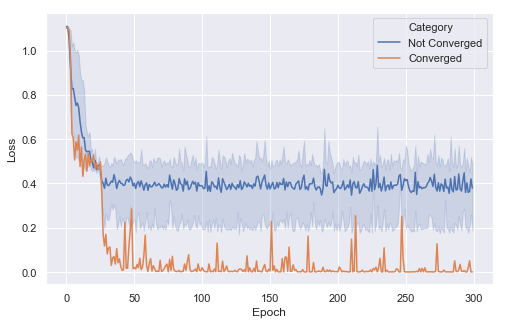

In [32]:
df = pd.DataFrame([
    {
        'Epoch': epoch,
        'Loss': train_item['loss'],
        'Experiment': f"Run {index}",
        'Category': 'Converged' if did_converge(experiment) else 'Not Converged'
    }
    for index, experiment in enumerate(experiments)
    for epoch, train_item in enumerate(experiment.training_history)
])

plt.figure(figsize=(8, 5))
sns.lineplot(x='Epoch', y='Loss', hue='Category', data=df);

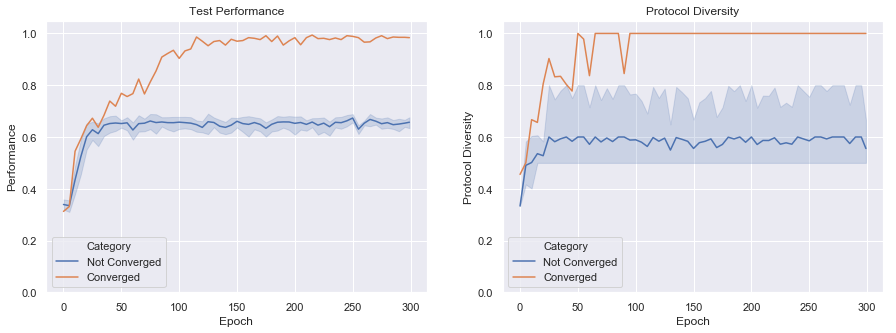

In [30]:
df = pd.DataFrame([
    {
        'Epoch': epoch,
        'Performance': train_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': train_item['test_metrics']['mean_protocol_diversity'],
        'Experiment': f"Run {index}",
        'Category': 'Converged' if did_converge(experiment) else 'Not Converged'
    }
    for index, experiment in enumerate(experiments)
    for epoch, train_item in enumerate(experiment.training_history)
    if 'test_metrics' in train_item
])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title('Test Performance')
axs[1].set_title('Protocol Diversity')

sns.lineplot(x='Epoch', y='Performance', hue='Category', data=df, ax=axs[0]);
sns.lineplot(x='Epoch', y='Protocol Diversity', hue='Category', data=df, ax=axs[1]);
for ax in axs:
    ax.set_ylim([0, 1.05])

In [25]:
games_played, _ = experiments[4].run_tests()

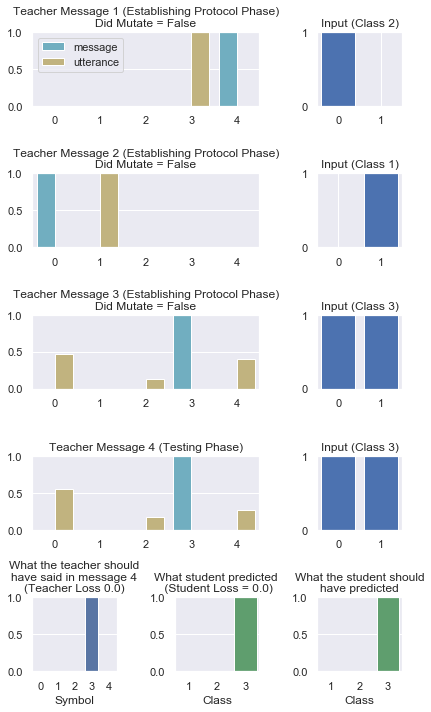

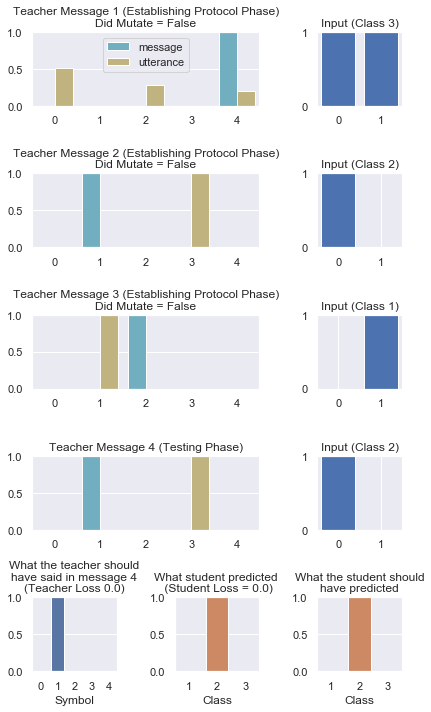

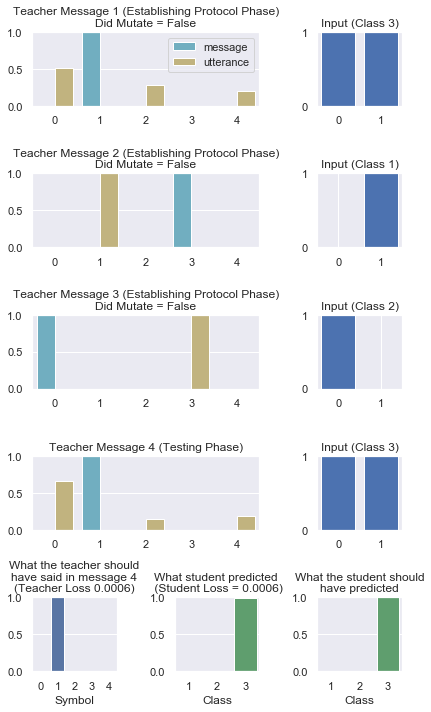

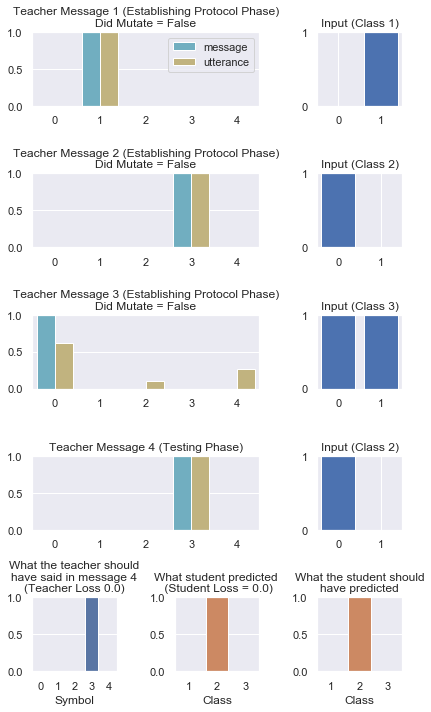

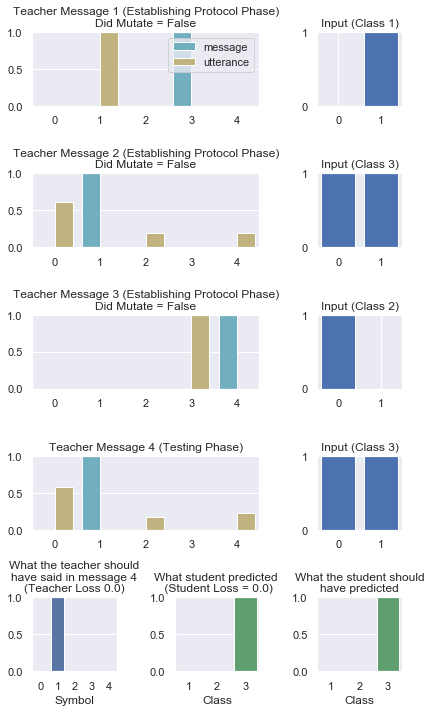

In [26]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=0)

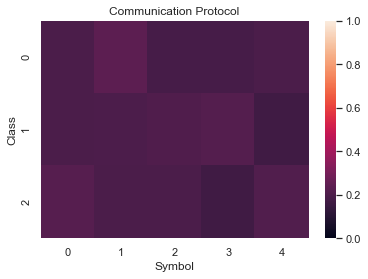

In [27]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

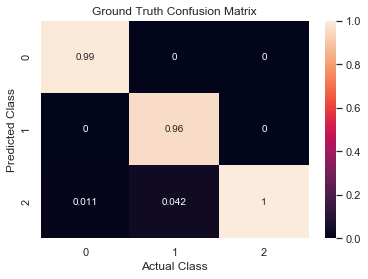

In [28]:
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');